# Notebook 4: Characterization of Long-Term Runoff

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, Band
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

## Introduction

In Notebook 2, we developed a rating curve for our location of interest based on discrete discharge measurements made during a series of visits, and we applied this stage-discharge relationship (rating curve) to the continous stage recorded at our hydrometric station (the datalogger recording from a pressure transducer).  Recall that our hydrometric station has only been running for a couple of years -- this isn't nearly enough data to estimate the flow characteristics (daily, seasonal, floods, droughts, etc.).  In this notebook, we look in the vicinity of our project location for other stations where records have been kept for much longer, i.e. several decades longer.

First, we'll set up our rating curve as we did in Notebook 2 and rebuild the daily average flow series.

## Import the Data

In [2]:
# import the stage data
stage_df = pd.read_csv('../data/CIVL418_2020_Nameless_Creek_H_data.csv', parse_dates=['Date'])
stage_df.set_index('Date', inplace=True)
stage_df.sort_index(inplace=True)
stage_df['Value'] = stage_df['Value'].astype(float)

In [3]:
# take a quick look at what we're dealing with
stage_df.head()

,ID,PARAM,year,month,day,Value
Date,,,,,,
2010-08-25,00XX000,2,2010,8,25,0.830
2010-08-26,00XX000,2,2010,8,26,0.876
2010-08-27,00XX000,2,2010,8,27,1.160
2010-08-28,00XX000,2,2010,8,28,0.867
2010-08-29,00XX000,2,2010,8,29,0.711


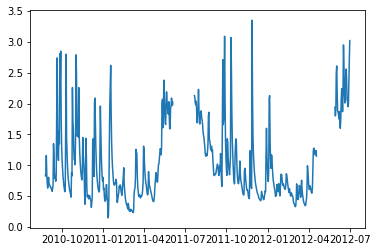

In [4]:
plt.plot(stage_df.index, stage_df['Value'])
plt.show()

In [5]:
# the water level (stage) label is long, 
# let's create a shortcut reference label
stage_label = 'water level (m above 0 flow ref)'
flow_label = 'Flow (m^3/s)'


In [6]:
# import the discharge measurements
rc_df = pd.read_csv('../data/project_QH_table_2020.csv', parse_dates=['Date'])

In [7]:
# take a look at the discharge measurements
rc_df

,Date,Flow (m^3/s),water level (m above 0 flow ref)
0,2010-12-24,4.340,1.130
1,2011-01-11,0.217,0.149
2,2011-05-04,3.470,1.020
3,2011-09-19,4.280,0.966
4,2011-10-24,4.510,1.070
5,2011-12-17,0.997,0.443
6,2012-01-26,2.480,0.648
7,2012-02-18,1.330,0.624
8,2012-02-24,1.540,0.516


## Plot the Stage-Discharge Rating Curve and the Best Fit Curve

Recall from Notebook 2: $Q = C(H-h_0)^b$.  If we transform the data to log space, we get a linear relationship:

$$log(Q) = log(C) + b\cdot log(h-h_0)$$

If we rearrange to the form $y = intercept + slope \cdot x$, we can use the scipy function for linear regression (`
()` from the previous tutorial).

Recall the x and y axis parameters are Q and h, respectively, so the linear form of the equation is then: 

$$log(h-h_0) = slope \cdot log(Q) + intercept$$

The above relationship is linear, so we can use ordinary least squares to find the best fit line (in log-log space), and then transform back to linear space.
Note that $h_0$ cannot be fitted this way, and has to be set manually. In this case we can assume $h_0=0$.

In [8]:
# calculate the discharge based on the best fit
# parameters found by ordinary least squares above
def ols_rc_q(slope, intercept, h, h0):
    """
    Calculate flow (Q) from the linear best fit parameters.
        -slope: the `log_slope` calculated above (constant)
        -intercept: `log_intercept` calculated above (constant)
        -h0 is the same PZF offset used above (constant)
        -h is the independent variable
    Returns Q, the discharge in m^3/s.
    """
    if slope == 0:
        return 0
    try:
        return np.exp((np.log(h - h0) - intercept) / slope)
    except ValueError: 
        return None

In [9]:
# Find the best-fit line in log-log space
# take the logarithm of the measured streamflows and stage
h0=0
q_log = np.log(rc_df[flow_label] - h0)
stage_log = np.log(rc_df[stage_label])

# find the parameters describing the linear best fit using ordinary least squares (OLS)
log_slope, log_intercept, log_rval, log_pval, log_stderr = st.linregress(q_log, stage_log)

In [10]:
stage_range = np.linspace(0.001, 1.5, 100)
# put best fit results into a dataframe for plotting
# use 0 as the PZF (point of zero flow) (the h0 parameter)
bf_df = pd.DataFrame()
bf_df['stage'] = stage_range

# now as before, apply the `ols_rc_q` function to create the stage-discharge
# curve based on the best-fit equation
bf_df['best_fit_q'] = [ols_rc_q(log_slope, log_intercept, h, 0.0) for h in stage_range]
bf_df.sort_values(by='stage', inplace=True)

## Calculate Daily Average Discharge

From the equation describing the ordinary least squares (OLS) best fit of the measured discharge,
calculate daily average flow from daily average water level.

In [11]:
stage_df['RC Q (cms)'] = stage_df['Value'].apply(lambda h: ols_rc_q(log_slope, log_intercept, h, 0))
stage_df['Date'] = stage_df.apply(lambda row: pd.to_datetime('{}-{}-{}'.format(row['year'], 
                                                                               row['month'],
                                                                              row['day'])), axis=1)

In [12]:
stage_df

,ID,PARAM,year,month,day,Value,RC Q (cms),Date
Date,,,,,,,,
2010-08-25,00XX000,2,2010,8,25,0.830,2.899688,2010-08-25
2010-08-26,00XX000,2,2010,8,26,0.876,3.155593,2010-08-26
2010-08-27,00XX000,2,2010,8,27,1.160,4.901088,2010-08-27
2010-08-28,00XX000,2,2010,8,28,0.867,3.104910,2010-08-28
2010-08-29,00XX000,2,2010,8,29,0.711,2.274967,2010-08-29
...,...,...,...,...,...,...,...,...
2012-06-27,00XX000,2,2012,6,27,1.950,11.065578,2012-06-27
2012-06-28,00XX000,2,2012,6,28,2.000,11.513670,2012-06-28
2012-06-29,00XX000,2,2012,6,29,2.380,15.123902,2012-06-29


### Plot the Rating Curve and Resultant Flow Series

The two plots below are linked.  Check the selection tools, and select points on one plot.  When validating data, it is helpful to be able to link the measurements on the rating curve plot and the daily flow series plot.  Consider how you would you check if the low flows were subject to a shift in the hydraulic control over time?    

In [14]:
# output to static HTML file
#output_file("filename.html")

# customize the tools for interacting with the bokeh plot
TOOLS="pan,wheel_zoom,reset,hover,poly_select,box_select"

# Bokeh uses a ColumnDataSource data structure to 
# link plots and make them more interactive
# set data sources for plot linking
stage_df.reset_index(inplace=True, drop=True)
rc_source = ColumnDataSource(data=dict())
rc_source.data = rc_source.from_df(rc_df)

ts_source = ColumnDataSource(data=dict())
ts_source.data = ts_source.from_df(stage_df)

#### RATING CURVE PLOT (LET)
rc_plot = figure(plot_width=550, plot_height=400,
                title='Rating Curve Plot',
                tools=TOOLS)

# plot the measured discharge points
rc_plot.circle(flow_label, stage_label, size=5, color="red", alpha=0.5,
              legend_label='Measured Q', source=rc_source)

# plot the rating curve based on the OLS best fit
rc_plot.line(bf_df['best_fit_q'], bf_df['stage'],
             line_color='green', legend_label='OLS Fit')

#### DAILY FLOW SERIES PLOT (RIGHT)
daily_flow_plot = figure(plot_width=550, plot_height=400, 
                        x_axis_type='datetime', title='Daily Flow Hydrograph')

# # plot the flow series based on the OLS best fit
daily_flow_plot.line('Date', 'RC Q (cms)', 
                    legend_label='OLS-based RC Flow', color='dodgerblue',
                    source=ts_source)

# plot the daily flow series generated from the manual rating curve
daily_flow_plot.circle('Date', flow_label, size=5, color="red", alpha=0.8,
              source=rc_source, legend_label='Measured Q')

# daily_flow_plot.line('Date', 'RC Q (cms)')
# label the axes
daily_flow_plot.xaxis.axis_label = 'Date'
daily_flow_plot.yaxis.axis_label = 'Flow (m³/s)'
daily_flow_plot.legend.location = "top_left"
rc_plot.xaxis.axis_label = 'Flow (m³/s)'
rc_plot.yaxis.axis_label = 'Stage (m)'
rc_plot.legend.location = "bottom_right"

layout = gridplot([[rc_plot, daily_flow_plot]])

# show the results
show(layout)

## Characterizing Water Resources

Below are a few points to consider regarding the characterization of the water resource over the **long term**.

1.  How long has the hydrometric station been operating?  
2.  If we're collecting data to support civil engineering design, to assess financial viability of a project, to inform operations, and to quantify the impact of our use of water resources or our modification of natural flow regimes, have we collected enough data?
3.  How much data is enough?
4.  If we don't have enough, what can we do to better evaluate the water resource?



## Linear Regression of Daily Streamflow

![Active WSC Stations in Western Canada](img/wsc_map_view1.png)

Water Survey of Canada (WSC) has operated and maintained hydrometric stations across Canada for over 100 years.  If we can find a regional proxy WSC station in **close proximity to our location of interest, with similar basin characteristics** to those of our project, we can correlate daily streamflow between the two locations, ultimately to generate an estimated (or synthetic) long-term flow series for our project location.

Typically regressions are done by chronological pairing, which effectively says "if the flow at the regional (proxy) station was $Q_p$ at time $t$, the flow at our project location at time $t$ will be approximately $C\cdot Q_p + D$ where $C$ and $D$ are constants.  

### Steps to develop a correlation: Chronological Pairing (CP)

A lot of work goes into finding an appropriate long-term record comparable to our location of interest, but we will assume we have been given a long-term daily flow series to use.

1.  Find just the concurrent days of record (days where we have flow recorded for both creeks/rivers).
2.  Create a scatter plot where the coordinates of each data point are (flow1, flow2).  It is customary to put the long-term regional station on the x-axis.
3.  Determine the equation describing the line of best fit through the data.
4.  Apply the best fit line equation to the long-term surrogate record to yield an estimated long-term series for the project location.

To further refine this estimate, we can recognize that the mechanisms driving flow across seasons and months can change quite dramatically, and the relationship between the two catchments can also change month-by-month, and/or season by season.  If there is enough data to create seasonal or monthly regressions, we can develop a best-fit equation for each month or season.  The process of steps 2 through 4 then are the same, except we treat each season or month independently.  

The above method is referred to as **chronological pairing (CP)**, as it pairs flow that occurs on the same day.  But what if there are timing differences between stations, or what if the spatial variability of precipitation results in flow events that don't coincide in the short term?  

### Empirical Frequency Pairing

To eliminate the temporal constraint on timing of events at the daily level, instead of comparing concurrent days, we can compare magnitudes of flows. This method is referred to as Empirical Frequency Pairing (EFP) and is commonly used in British Columbia.  Empirical frequency pairing still uses concurrent records, however it is the ranked flows in each series that are compared, i.e. the data points on an EFP plot are:  

$$[(R1_{siteA}, R1_{site_B}), (R2_{siteA}, R2_{siteB}), ..., (Rn_{siteA}, Rn_{siteB})]$$  

The steps to derive an estimated long-term flow series for our location of interest are the same (i.e. steps 2-4 above).

### Setting up a Regression

The first step is to import the regional data series and find all of the dates with values for both locations.

Previewing the data shows line 1 has information about two distinct parameters.  Where the `PARAM` column value is 1, the `Value` column corresponds to daily discharge ($\frac{m^3}{s}$ and where the `PARAM` column value is 2, the `Value` column corresonds to daily water level ($m$).  We need to correctly set the header line to index 1 (the second row), so that the headings are read correctly.

In [15]:
# set the header row to index 1, tell the function to set the `Date` column as the index.
# If you look at the raw csv file, you'll see that there's an information line at the very top,
# and the second line (index 1 in programming) is where the column headers are
regional_df = pd.read_csv('../data/notebook_2_data/Regional_data.csv', header=1, parse_dates=True, index_col='Date')

# select only the discharge data (PARAM == 1)
regional_df = regional_df[regional_df['PARAM'] == 1]

regional_df.columns = ['PARAM', 'Regional Flow (m^3/s)', 'SYM']

# preview the data
regional_df.head()

,PARAM,Regional Flow (m^3/s),SYM
Date,,,
1987-01-26,1,0.283,A
1987-01-27,1,0.240,B
1987-01-28,1,0.240,B
1987-01-29,1,0.273,NaN
1987-01-30,1,0.255,NaN


In [16]:
# check the date range covered by the regional data
print('REGIONAL DATA: Start date = {}, End date = {}'.format(regional_df.index[0], regional_df.index[-1]))

# we need to set the index again to the date for stage_df
stage_df.set_index('Date', inplace=True)
# check the date range covered by our data measured at site
print('SITE DATA: Start date = {}, End date = {}'.format(stage_df.index[0], stage_df.index[-1]))

REGIONAL DATA: Start date = 1987-01-26 00:00:00, End date = 2017-12-31 00:00:00
SITE DATA: Start date = 2010-08-25 00:00:00, End date = 2012-07-01 00:00:00


### Obtain Concurrent Data

In the previous step, we can see that the regional dataset encompasses the date range of our site data.  To perform a regression, we want to use concurrent data only.   The `concat`, or concatenate, function [documentation can be found here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html). 

In [19]:
# create a new dataframe of concurrent data and plot the data
# join='inner' says to line up the indices and get the values that are common between the two dataframes
# axis=1 says line up columns instead of rows
concurrent_df = pd.concat([stage_df, regional_df], join='inner', axis=1)

# filter just the columns we want
concurrent_df = concurrent_df[['Regional Flow (m^3/s)', 'RC Q (cms)']]

print(concurrent_df)


# not rename the columns to something that is more indicative of the location of each data source
concurrent_df.columns = ['Regional_Q', 'Project_Q']
concurrent_df.head()

concurrent_df.dropna(inplace=True)


            Regional Flow (m^3/s)  RC Q (cms)
Date                                         
2010-08-25                  1.930    2.899688
2010-08-26                  1.910    3.155593
2010-08-27                  1.410    4.901088
2010-08-28                  1.110    3.104910
2010-08-29                  0.996    2.274967
...                           ...         ...
2012-06-27                  4.110   11.065578
2012-06-28                  3.580   11.513670
2012-06-29                  4.140   15.123902
2012-06-30                  6.540   18.538791
2012-07-01                  5.000   21.970086

[677 rows x 2 columns]


In [20]:
# find the best fit equation
slope, intercept, rval, pval, stderr = st.linregress(concurrent_df['Regional_Q'], concurrent_df['Project_Q'])

# Regression Plot

In [21]:
#### Regression Plot
reg_plot = figure(plot_width=700, plot_height=400,
                title='Regression Plot (All Concurrent Data)',
                tools=TOOLS)

# plot the concurrent daily flows
reg_plot.scatter(concurrent_df['Regional_Q'], concurrent_df['Project_Q'],
                color='dodgerblue')

#plot the best fit
q_range = np.linspace(0, concurrent_df['Regional_Q'].max(), 500)

reg_line = [slope * q + intercept for q in q_range]

reg_plot.line(q_range, reg_line, legend_label='Q = {:.1f}*Qregional + {:.1f}'.format(slope, intercept),
             color='firebrick', line_width=2)

show(reg_plot)
# plt.xlabel('Regional Station Daily Avg. Flow (m^3/s)')
# plt.ylabel('Project Location Daily Avg. Flow (m^3/s)')

## Estimate Long-Term Daily Flow at Project Location

The last step in the process of a long-term flow estimate for our project location is to use the equation of the best fit line (the model) to calculate estimated daily flows over periods where flow was not measured at our project location.

In [22]:
lt_series = regional_df.copy()[['Regional Flow (m^3/s)']]
lt_series.columns = ['Regional_Q']
# map the equation of the best fit line to the regional flow series
lt_series['Proj_Q'] = lt_series.apply(lambda q: slope * q + intercept, axis=1)

## Compare the Modelled vs. Measured Flow


In [23]:
mod_df = pd.concat([stage_df, lt_series], join='inner', axis=1)
# keep only the measured and modeled columns
mod_df = mod_df[['RC Q (cms)', 'Proj_Q']]
# rename the columns to something more intuitive
mod_df.columns = ['Measured_Q', 'Modeled_Q']

mod_df.dropna(inplace=True)

reg_plot = figure(plot_width=700, plot_height=400,
                title='Measured vs. Modeled Daily Avg. Flow',
                tools=TOOLS, x_axis_type='datetime')

reg_plot.line(mod_df.index, mod_df['Measured_Q'], line_width=2,
             color='dodgerblue', legend_label='Measured Q')

reg_plot.line(mod_df.index, mod_df['Modeled_Q'], line_width=2,
             color='darkblue', legend_label='Modeled Q',
             line_dash='dashed')

show(reg_plot)

### In the above plot, note general patterns, specific exceptions, and any trends

Note the big deviation between the two series in the summer of 2010.  This looks like our model is doing a particularly bad job in the late summer.  How about in other seasons?   How is the model doing at predicting peaks?  

How else can we evaluate how the model is fitting the measured data, noting in particular that we are interested in certain ranges of flows, perhaps for generating energy year-round, or supplying a community with drinking water in a dry season?

Recall how we plotted the flow duration curve in Notebook 3.  The flow duration curve is particularly useful for focusing on how well the model matches measured data across the range of flows (though extremes are de-emphasized).  

### Plot a comparison of Flow Duration Curves

In [24]:
pct_exceeded = np.linspace(0, 100, 200)
msd_quantiles = np.percentile(mod_df['Measured_Q'], pct_exceeded)
modeled_quantiles = np.percentile(mod_df['Modeled_Q'], pct_exceeded)

fdc_plot = figure(width=700, height=400, title='Measured vs. Modeled Flow Duration Curve')
fdc_plot.line(pct_exceeded[::-1], msd_quantiles, legend_label="Measured", line_width=2,
             color='dodgerblue')
fdc_plot.line(pct_exceeded[::-1], modeled_quantiles, line_width=2,
             color='darkblue', legend_label='Modeled', line_dash='dashed')
fdc_plot.yaxis.axis_label = 'Flow [m^3/s]'
fdc_plot.xaxis.axis_label = 'Percent of Time Exceeded [%]'
show(fdc_plot)

### Estimate the Long-Term Mean Annual Flow for our Project Location

Compare the long term mean annual against the short term, then compare the long-term monthly and annual series.

In [25]:
lt_mad = lt_series[['Proj_Q']].mean().to_numpy()[0]
msd_mean = stage_df[['RC Q (cms)']].mean().to_numpy()[0]

print('The mean annual flow (MAD) at our project location is {:.1f} m^3/s'.format(lt_mad))
print('To compare, the average flow over the measured period was {:.1f} m^3/s'.format(msd_mean))

The mean annual flow (MAD) at our project location is 5.6 m^3/s
To compare, the average flow over the measured period was 4.7 m^3/s


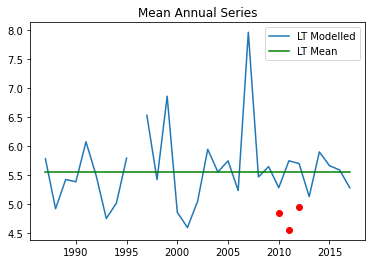

In [26]:
lt_series['year'] = lt_series.index.year
annual_series = lt_series[['Proj_Q', 'year']].groupby('year').mean()

stage_df['year'] = stage_df.index.year
msd_ann = stage_df[['year', 'RC Q (cms)']].groupby('year').mean()

plt.plot(annual_series['Proj_Q'], label='LT Modelled')
plt.plot([1987, 2017], [lt_mad, lt_mad], label='LT Mean', color='green')
plt.scatter(msd_ann.index, msd_ann['RC Q (cms)'], color='red')
plt.title('Mean Annual Series')
plt.legend()
plt.show()

## Questions for Submission on Canvas

1.  From our regression plot and from the comparison of measured and estimated daily flow series, what do you think about the quality of our model, i.e. how well does the best fit line approximate the concurrent daily flows (blue dots)?  
2.  What range of flow is exceeded 67% OR MORE of the time, how well is this range modelled and what might this flow range be pertinent to?  
3.  What could differences in concurrent flows at the two locations be attributable to?  
4.  How might we modify our model to capture one of the differences you noted in 3?
5.  In the last plot, we see that the ~two years we measured flow at our project location were very close to the long-term mean annual.  What if the two years we happened to measure were 2000 and 2001 and we took these as representative without doing a regression analysis with a long-term regional record?

## References

1. A.S. Hamilton & R.D. Moore (2012). Quantifying Uncertainty in Streamflow Records , Canadian Water Resources Journal / Revue canadienne des ressources hydriques, 37:1, 3-21, DOI: 10.4296/cwrj3701865
2. Environment Canada (2012).  Hydrometric Manual - Data Computations.  Water Survey of Canada, Weather and Environmental Monitoring Directorate.